In [33]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
AUTOTUNE = tf.data.experimental.AUTOTUNE

from keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import os
import numpy as np
import matplotlib.pyplot as plt
batchsize = 10
NUM_EPOCHS = 10
#img_width, img_height = 150, 150
#for VGG 16 use 224 image size
img_width, img_height = 224, 224

num_train_images = 4024
num_val_images = 423

In [4]:
import zipfile

path = "/content/drive/MyDrive/bedchairothers.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [7]:
import pathlib
train_dir = '/content/furniture-images/img/train'
val_dir = '/content/furniture-images/img/val'
train_dir = pathlib.Path(train_dir)
val_dir = pathlib.Path(val_dir)
output_dir = 'furniture_images/'

In [9]:
train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'))
val_ds = tf.data.Dataset.list_files(str(val_dir/'*/*'))
class_list = ["bed", "chair", "sofa", "swivelchair", "table"]

In [10]:
for f in train_ds.take(5):
  print(f.numpy())

b'/content/furniture-images/img/train/table/00000374.jpg'
b'/content/furniture-images/img/train/chair/00000238.jpg'
b'/content/furniture-images/img/train/table/00000280.jpg'
b'/content/furniture-images/img/train/bed/00000455.jpg'
b'/content/furniture-images/img/train/chair/00000615.jpg'


In [11]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == class_list

In [12]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [img_width, img_height])

In [13]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [19]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_labeled_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True False False False]


In [20]:
val_labeled_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in val_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False  True False False]


In [21]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(batchsize)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [22]:
train_ds = prepare_for_training(train_labeled_ds)

train_image_batch, label_batch = next(iter(train_ds))

val_ds = prepare_for_training(val_labeled_ds)

val_image_batch, label_batch = next(iter(val_ds))

In [26]:
base_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=(img_height, img_width, 3))

In [27]:
def build_final_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    
    x = GlobalAveragePooling2D()(x)
   
    x = Flatten()(x)
    
    fine_tune_at = 100

    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False

    
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    predictions = Dense(num_classes, activation='softmax')(x) 
    
    final_model = Model(inputs=base_model.input, outputs=predictions)

    return final_model

class_list = ["bed", "chair", "sofa", "swivelchair", "Table"]
FC_LAYERS = [1024, 1024]
dropout = 0.3

model = build_final_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [30]:
outputpath=output_dir+"/model-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint_callback = ModelCheckpoint(outputpath, monitor='val_accuracy', verbose=1,save_best_only=False, save_weights_only=False,save_frequency=1)

In [34]:
adam = Adam(lr=0.00001)
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds,epochs=NUM_EPOCHS,steps_per_epoch=num_train_images // batchsize,callbacks=[checkpoint_callback],validation_data=val_ds, validation_steps=num_val_images // batchsize)

Epoch 1/10
402/402 [==============================] - 31s 58ms/step - loss: 1.5923 - accuracy: 0.2626 - val_loss: 1.3242 - val_accuracy: 0.5952

Epoch 00001: saving model to furniture_images/model-01-0.60.hdf5
Epoch 2/10
402/402 [==============================] - 23s 58ms/step - loss: 1.3508 - accuracy: 0.5068 - val_loss: 1.0554 - val_accuracy: 0.7381

Epoch 00002: saving model to furniture_images/model-02-0.74.hdf5
Epoch 3/10
402/402 [==============================] - 24s 59ms/step - loss: 1.1008 - accuracy: 0.6496 - val_loss: 0.8496 - val_accuracy: 0.7619

Epoch 00003: saving model to furniture_images/model-03-0.76.hdf5
Epoch 4/10
402/402 [==============================] - 24s 59ms/step - loss: 0.8873 - accuracy: 0.7166 - val_loss: 0.7260 - val_accuracy: 0.7905

Epoch 00004: saving model to furniture_images/model-04-0.79.hdf5
Epoch 5/10
402/402 [==============================] - 24s 59ms/step - loss: 0.7566 - accuracy: 0.7565 - val_loss: 0.6311 - val_accuracy: 0.7952

Epoch 00005: sa

In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [36]:
print(len(model.layers))

26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


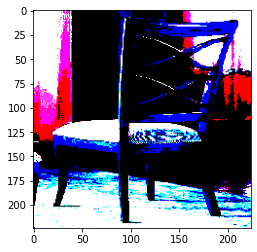

In [37]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

img_path = '/content/furniture-images/img/val/chair/00000016.jpg'
#img_path = 'furniture_images/test/bed/00000876trainbed.jpg'
#img_path = 'furniture_images/test/sofa/00000803testsofa.jpg'
img = image.load_img(img_path, target_size=(img_height, img_width))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

featuremap = model.predict(img_tensor)
plt.imshow(featuremap)
plt.imshow(img_tensor[0])
print (img_tensor.shape)

In [38]:
from tensorflow.keras.models import Model
layer_outputs = [layer.output for layer in model.layers[:len(model.layers)]]
activation_modelfig = Model(inputs=model.input, outputs=layer_outputs)
activationsfig = activation_modelfig.predict(img_tensor)

(1, 224, 224, 3)


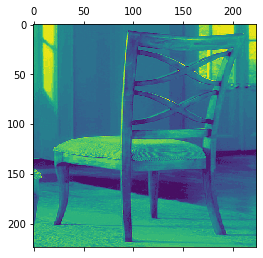

In [39]:
first_layer_activation = activationsfig[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curr

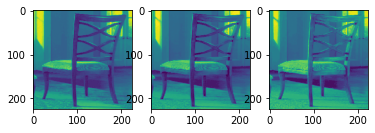

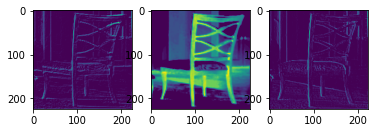

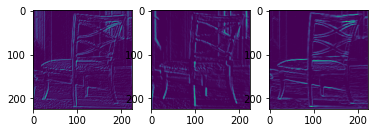

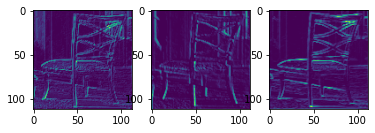

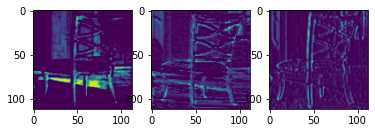

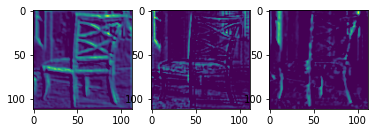

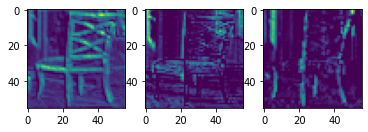

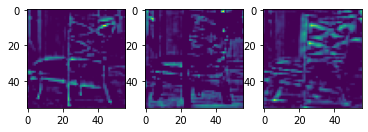

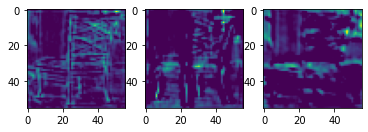

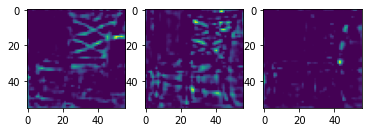

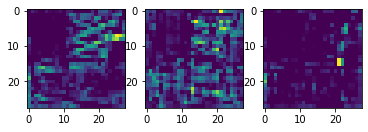

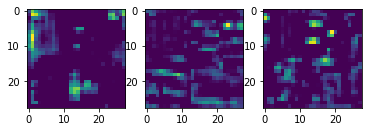

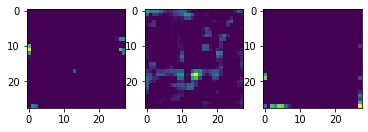

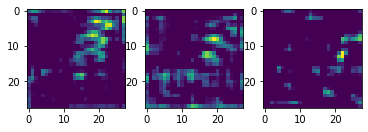

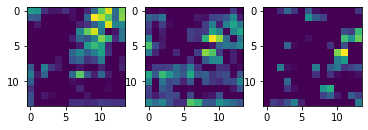

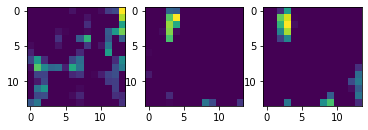

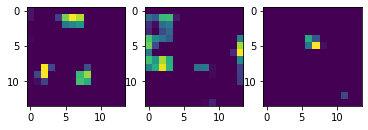

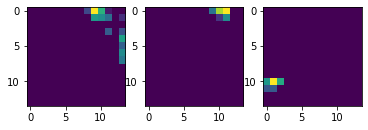

In [40]:
for i in range(0,len(model.layers)-8):
    current_layer_activation = activationsfig[i]
    ns = current_layer_activation.shape[-1]
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    plt.subplot(131)
    plt.imshow(current_layer_activation[0, :, :, 0], cmap='viridis')
    
    ax3 = fig.add_subplot(132)
    plt.subplot(132)
    plt.imshow(current_layer_activation[0, :, :, int(ns/2)], cmap='viridis')
    
    ax5 = fig.add_subplot(133)
    plt.subplot(133)
    plt.imshow(current_layer_activation[0, :, :, ns-1], cmap='viridis')

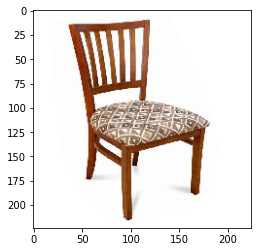

In [48]:
#img_path = '/content/image-emperor-low-footend-wooden-bed-frame.jpg'
img_path ='/content/d462646334bba9b243c37a302b9b82f7.jpg'
#img_path = '/content/img27c.jpg'

img_show = image.load_img(img_path, target_size=(img_width, img_height))
plt.imshow(img_show)

In [49]:
img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

vgg_feature = model.predict(img_data,verbose=0)
vgg_feature_np = np.array(vgg_feature)
print(vgg_feature_np)
vgg_feature1D = vgg_feature_np.flatten()
print(vgg_feature1D)
y_prob = model.predict(img_data)
y_classes = y_prob.argmax(axis=-1)
print(y_classes)

[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 2.1622959e-32]]
[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 2.1622959e-32]
[1]


In [50]:
from scipy.spatial import distance as dist
from sklearn.metrics.pairwise import cosine_similarity
if y_classes == [0]:
    path = '/content/furniture-images/img/val/bed'
elif y_classes == [1]:
    path = '/content/furniture-images/img/val/chair'
elif y_classes == [2]:
    path = '/content/furniture-images/img/val/sofa'
elif y_classes == [3]:
    path = '/content/furniture-images/img/val/swivelchair'
else:
    path = '/content/furniture-images/img/val/table'        

In [52]:
mindist=10000
maxcosine = 0
i=0
for filename in os.listdir(path):
    image_train = os.path.join(path, filename)
    i +=1
    imgtrain = image.load_img(image_train, target_size=(224, 224))
    img_data_train = image.img_to_array(imgtrain)
    img_data_train = np.expand_dims(img_data_train, axis=0)
    img_data_train = preprocess_input(img_data_train)
    vgg_feature_train = model.predict(img_data_train)
    vgg_feature_np_train = np.array(vgg_feature_train)
    vgg_feature_train1D = vgg_feature_np_train.flatten()
    eucldist = dist.euclidean(vgg_feature1D,vgg_feature_train1D)
    if mindist > eucldist:
        mindist=eucldist
        minfilename = filename
        #print (vgg16_feature_np)
    dot_product = np.dot(vgg_feature1D,vgg_feature_train1D)
    #normalize the results, to achieve similarity measures independent 
    #of the scale of the vectors
    norm_Y = np.linalg.norm(vgg_feature1D)
    norm_X = np.linalg.norm(vgg_feature_train1D)
    cosine_similarity = dot_product / (norm_X * norm_Y)
    if maxcosine < cosine_similarity:
        maxcosine=cosine_similarity
        cosfilename = filename
    print ("%s filename %f euclediandist %f cosine_similarity" %(filename,eucldist,cosine_similarity))
    print ("%s minfilename %f mineuclediandist %s cosfilename %f maxcosinesimilarity" %(minfilename,mindist, cosfilename, maxcosine))

00000079.jpg filename 0.000000 euclediandist 1.000000 cosine_similarity
00000079.jpg minfilename 0.000000 mineuclediandist 00000079.jpg cosfilename 1.000000 maxcosinesimilarity
00000071.jpg filename 0.000000 euclediandist 1.000000 cosine_similarity
00000071.jpg minfilename 0.000000 mineuclediandist 00000079.jpg cosfilename 1.000000 maxcosinesimilarity
00000069.jpg filename 0.000000 euclediandist 1.000000 cosine_similarity
00000071.jpg minfilename 0.000000 mineuclediandist 00000079.jpg cosfilename 1.000000 maxcosinesimilarity
00000058.jpg filename 0.000000 euclediandist 1.000000 cosine_similarity
00000058.jpg minfilename 0.000000 mineuclediandist 00000079.jpg cosfilename 1.000000 maxcosinesimilarity
00000019.jpg filename 0.000000 euclediandist 1.000000 cosine_similarity
00000058.jpg minfilename 0.000000 mineuclediandist 00000079.jpg cosfilename 1.000000 maxcosinesimilarity
00000063.jpg filename 0.000000 euclediandist 1.000000 cosine_similarity
00000058.jpg minfilename 0.000000 mineucled

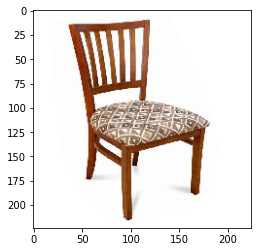

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
image_result = os.path.join(path, minfilename)
imgresult = image.load_img(image_train, target_size=(224, 224))
plt.imshow(img)

Text(0.5, 1.0, 'Cosine_Similarity 1.0000000')

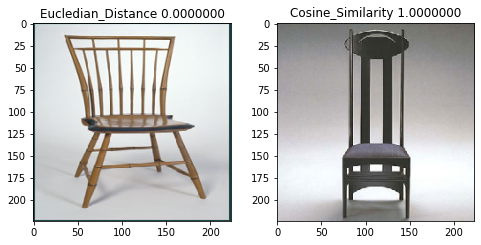

In [54]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(2,2,1)
image_result1 = os.path.join(path, minfilename)
imgresult1 = image.load_img(image_result1, target_size=(224, 224))
plt.imshow(imgresult1)
eucledian5d ="%.7f" % mindist
plt.title("Eucledian_Distance " + str(eucledian5d))

fig.add_subplot(2,2,2)
image_result2 = os.path.join(path, cosfilename)
imgresult2 = image.load_img(image_result2, target_size=(224, 224))
plt.imshow(imgresult2)
cosine5d ="%.7f" % maxcosine
plt.title("Cosine_Similarity " + str(cosine5d))

In [55]:
import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(batchsize*steps/duration))

In [56]:
train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(img_height, img_width), 
                                                    batch_size=batchsize)

Found 4024 images belonging to 5 classes.


In [57]:
timeit(train_generator)

....................................................................................................
1000 batches: 106.47950458526611 s
93.91479 Images/s


In [58]:
timeit(train_ds)

....................................................................................................
1000 batches: 1.3317909240722656 s
7508.68610 Images/s
